In [2]:
#import các thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from scipy import stats
import matplotlib.dates as mdates
from plotly import tools
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima
from prophet import Prophet

In [3]:
import mplfinance as mpf
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

# **DATA CLEANING**

In [9]:
#đọc file dữ liệu, đưa vào dataframe df
df = pd.read_csv(r'D:\download\mymy\TSE\all_stocks_5yr.csv')
#in lên 5 dòng đầu tiên của dataframe df
df.head().style.set_properties(**{'background-color': 'black',
                                    'color': 'lawngreen',
                                    'border': '1.5px  white'})


,date,open,high,low,close,volume,Name
0,2013-02-08,15.070000,15.120000,14.630000,14.750000,8407500,AAL
1,2013-02-11,14.890000,15.010000,14.260000,14.460000,8882000,AAL
2,2013-02-12,14.450000,14.510000,14.100000,14.270000,8126000,AAL
3,2013-02-13,14.300000,14.940000,14.250000,14.660000,10259500,AAL
4,2013-02-14,14.940000,14.960000,13.160000,13.990000,31879900,AAL


In [4]:
# đổi tên cột "Name" thành "ticks" vì "ticks" là thường được sử dụng trong lĩnh vực tài chính để chỉ mã cổ phiếu hoặc mã giao dịch
rdf = df.rename(columns={'Name':'ticks'})
# Loại bỏ các giá trị null vì chúng chỉ có vài giá trị và chuỗi thời gian sẽ không bị ảnh hưởng bởi những giá trị này.
rdf.dropna(inplace=True)
# đổi kiểu dữ liệu của cột date
new_df = rdf.copy()
new_df['date'] = pd.to_datetime(rdf['date'], errors='coerce') 
# thông tin của dataframe mới
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619029 non-null  float64       
 3   low     619029 non-null  float64       
 4   close   619029 non-null  float64       
 5   volume  619029 non-null  int64         
 6   ticks   619029 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


Tìm ra Top 10 cổ phiếu có khối lượng giao dịch cao nhất

In [5]:
# Tạo một từ điển để lưu trữ khối lượng giao dịch trung bình của mỗi cổ phiếu
mean_dict = {}

# Tìm khối lượng giao dịch trung bình trong một khoảng thời gian sử dụng vòng lặp for
for key in new_df['ticks'].unique():
    value = new_df[new_df['ticks'] == key]['volume'].mean()
    mean_dict[key] = value
# In ra độ dài của từ điển chứa khối lượng giao dịch trung bình
print("Độ dài của từ điển chứa khối lượng giao dịch trung bình là:", len(mean_dict))
# Chuyển đổi từ điển thành DataFrame của pandas
avaerage_s = pd.Series(mean_dict).transpose()
top10_s = avaerage_s.sort_values(ascending=False)[:10]
# In ra 10 mã cổ phiếu có khối lượng giao dịch trung bình cao nhất
print("Top 10 mã cổ phiếu có khối lượng giao dịch trung bình cao nhất:\n", top10_s.index)


Độ dài của từ điển chứa khối lượng giao dịch trung bình là: 505
Top 10 mã cổ phiếu có khối lượng giao dịch trung bình cao nhất:
 Index(['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO'], dtype='object')


Lọc ra dữ liệu cổ phiếu của Apple và Facebook

In [6]:
def subdataframe(df, tick):
    
    # Lấy danh sách 10 mã cổ phiếu hàng đầu
    ticks = list(top10_s.index)
    
    # Kiểm tra xem mã cổ phiếu có nằm trong danh sách 10 cổ phiếu hàng đầu không
    assert tick in ticks, """Mã cổ phiếu không nằm trong top 10 cổ phiếu hàng đầu, hãy thử đổi sang các mã cổ phiếu này:\n
    ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']"""
    
    # Lọc DataFrame để chỉ lấy các hàng có mã cổ phiếu (tick) tương ứng
    ndf = new_df[new_df['ticks'] == tick]
    
    # Trả về DataFrame con
    return ndf

#Tạo một từ điển company_dict để ánh xạ các mã cổ phiếu (tick) sang tên công ty tương ứng
company_dict = {'BAC':'Bank of America', 
                'AAPL':'Apple', 
                'FB':'Facebook', 
               }
#Lấy dữ liệu cho từng cổ phiếu
aapl_df = subdataframe(new_df, 'AAPL')
fb_df = subdataframe(new_df, 'FB')

In [7]:
#in lên 5 dòng đầu tiên của dataframe cổ phiếu aapl
aapl_df.head().style.set_properties(**{'background-color': 'black',
                                    'color': 'lawngreen',
                                    'border': '1.5px  white'})

,date,open,high,low,close,volume,ticks
1259,2013-02-08 00:00:00,67.714200,68.401400,66.892800,67.854200,158168416,AAPL
1260,2013-02-11 00:00:00,68.071400,69.277100,67.607100,68.561400,129029425,AAPL
1261,2013-02-12 00:00:00,68.501400,68.911400,66.820500,66.842800,151829363,AAPL
1262,2013-02-13 00:00:00,66.744200,67.662800,66.174200,66.715600,118721995,AAPL
1263,2013-02-14 00:00:00,66.359900,67.377100,66.288500,66.655600,88809154,AAPL


In [8]:
#in lên 5 dòng đầu tiên của dataframe cổ phiếu fb
fb_df.head().style.set_properties(**{'background-color': 'black',
                                    'color': 'lawngreen',
                                    'border': '1.5px  white'})

,date,open,high,low,close,volume,ticks
218609,2013-02-08 00:00:00,28.890000,29.170000,28.510000,28.545000,37662614,FB
218610,2013-02-11 00:00:00,28.610000,28.680000,28.040000,28.260000,36979533,FB
218611,2013-02-12 00:00:00,27.670000,28.160000,27.100000,27.370000,93417215,FB
218612,2013-02-13 00:00:00,27.360000,28.320000,27.310000,27.907500,50100805,FB
218613,2013-02-14 00:00:00,28.020000,28.630000,28.010000,28.500000,35581045,FB


# **Phân tích các thành phần thời gian (DECOMPOSITION)**

In [9]:
#Tạo một hàm để định dạng dataframe cho dự báo
def df_formatting(df):
    df = df.loc[:, ['date','close']]
    df.rename(columns={'date':'ds', 'close':'y'}, inplace=True)
    return df
aplph_df = df_formatting(aapl_df)
fbph_df = df_formatting(fb_df)
#lưu 2 bảng dữ liệu này để tạo mô hình Prophet ở file code riêng
aplph_df.to_csv(r'D:\download\mymy\TSE\aplph.csv',index=False)
fbph_df.to_csv(r'D:\download\mymy\TSE\fbph.csv',index=False)

C:\Users\MY\AppData\Local\Temp\ipykernel_28336\2617450163.py:10: UserWarning:

The figure layout has changed to tight



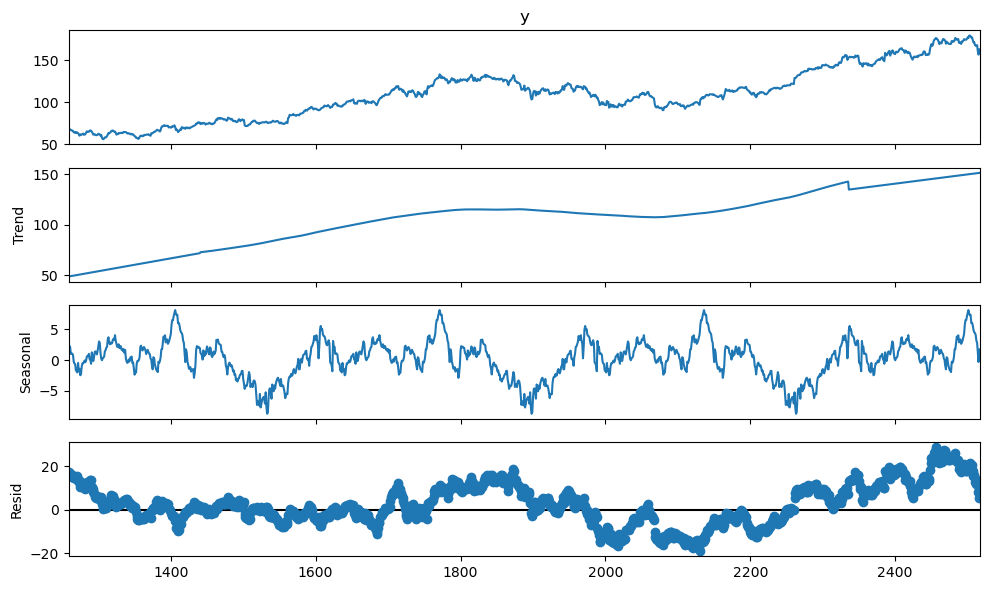

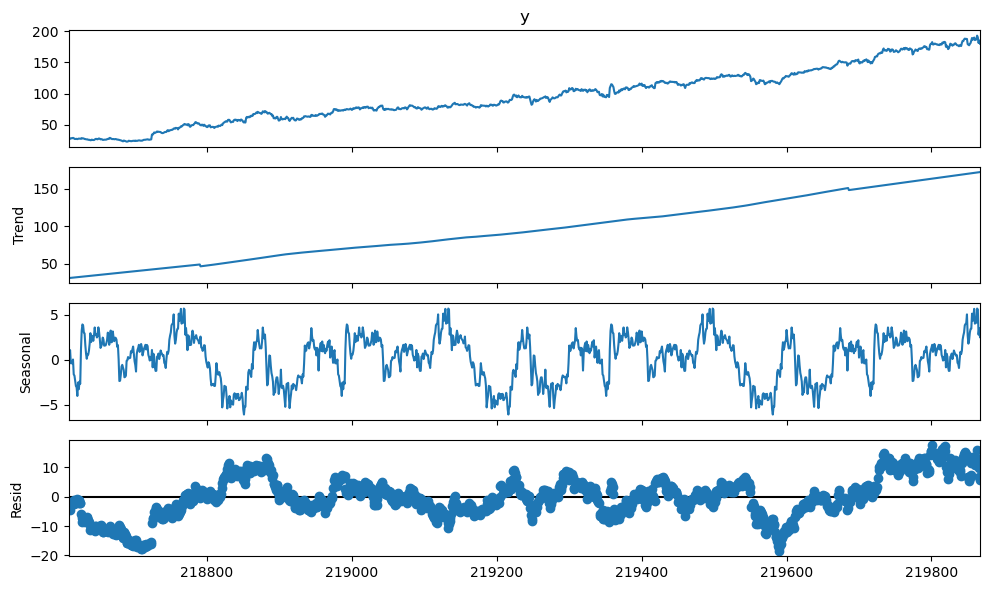

In [10]:

# hàm để thực hiện phân tích thành phần mùa vụ (seasonal decomposition) cho mô hình chuỗi thời gian
def decomposition(df, period):
    # Phân tích chuỗi thời gian thành 3 phần bằng hàm seasonal_decompose
    result_decom = seasonal_decompose(df['y'], model="additive", 
                                      period=period, extrapolate_trend='freq')
    # Vẽ biểu đồ thành phần
    fig = result_decom.plot()
    fig.set_size_inches((10, 6))
    # Căn chỉnh lại bố cục của biểu đồ
    fig.tight_layout()
    plt.show()
    
    # Lưu trữ các thành phần
    trend = result_decom.trend #Lưu trữ thành phần xu hướng
    season = result_decom.seasonal #Lưu trữ thành phần mùa vụ
    reside = result_decom.resid #Lưu trữ phần dư
    return trend, season, reside

# phân tích các thành phần chuỗi thời gian cho cổ phiếu appl
tr, se, re = decomposition(aplph_df, 365)

# phân tích các thành phần chuỗi thời gian cho cổ phiếu fbph
ftr, fse, fre = decomposition(fbph_df, 365)


# **Xây dựng mô hình Prophet** 


In [4]:
#đọc file dữ liệu, đưa vào dataframe df
aplph_df = pd.read_csv(r'D:\download\mymy\TSE\aplph.csv')
fbph_df=pd.read_csv(r'D:\download\mymy\TSE\fbph.csv')


03:13:41 - cmdstanpy - INFO - Chain [1] start processing


Dữ liệu tách cho công ty APPLE
Kích thước tập huấn luyện: 1196, Kích thước tập kiểm tra: 63
-------------------------------
Dữ liệu tách cho công ty FB
Kích thước tập huấn luyện: 1196, Kích thước tập kiểm tra: 63
-------------------------------


03:13:42 - cmdstanpy - INFO - Chain [1] done processing
03:13:43 - cmdstanpy - INFO - Chain [1] start processing
03:13:43 - cmdstanpy - INFO - Chain [1] done processing


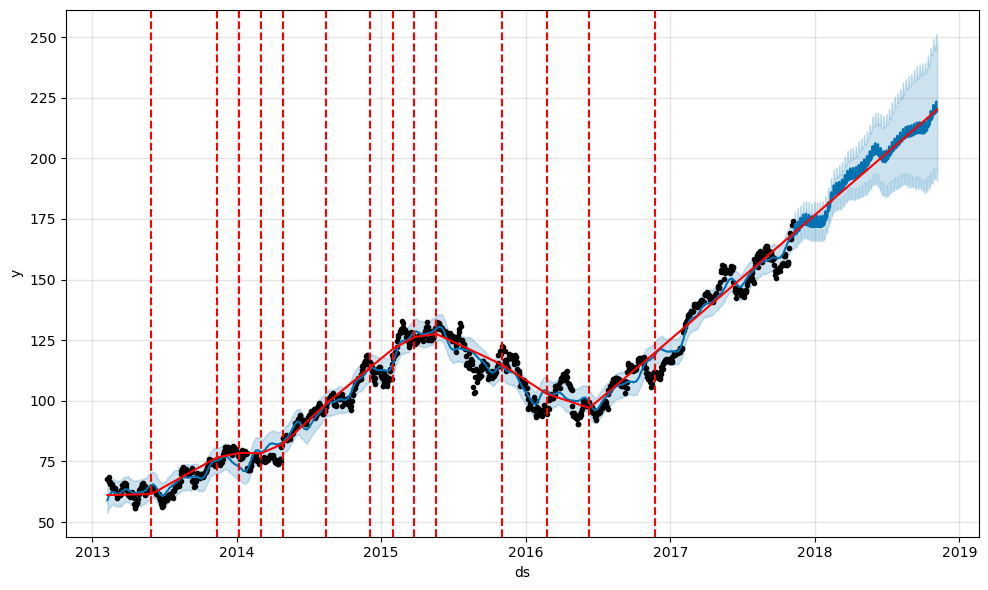

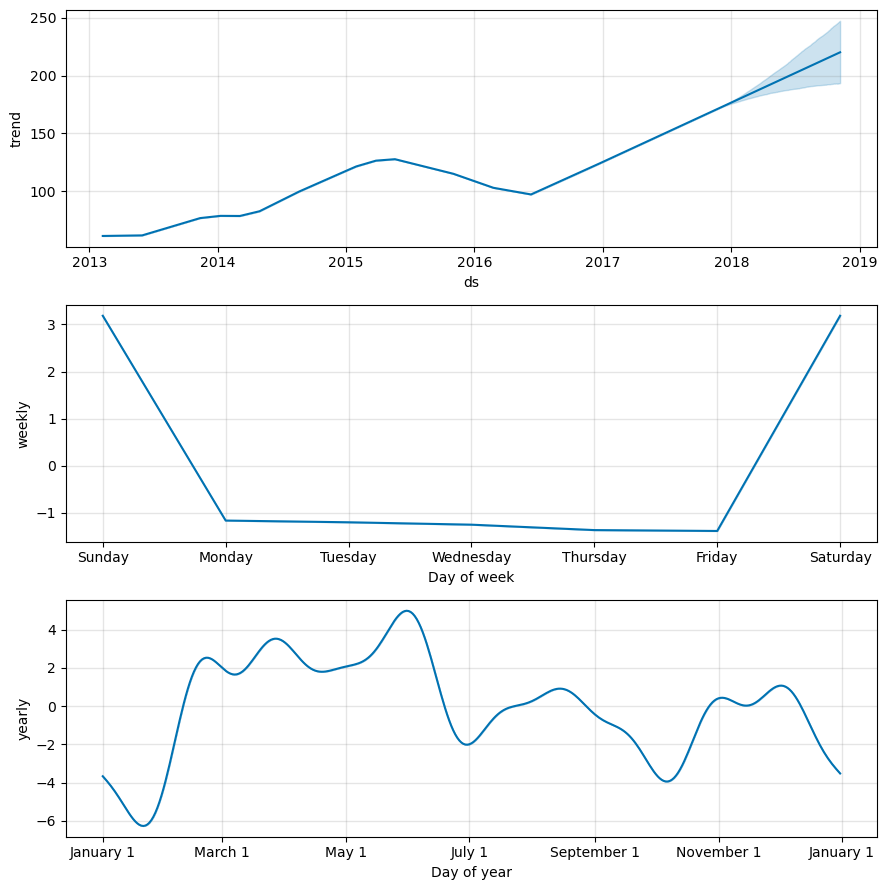

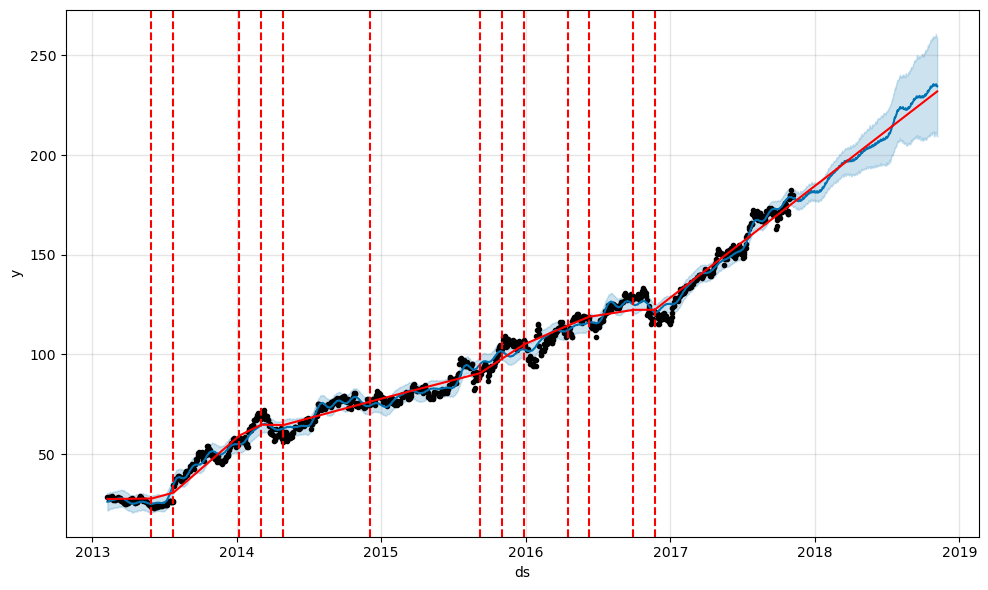

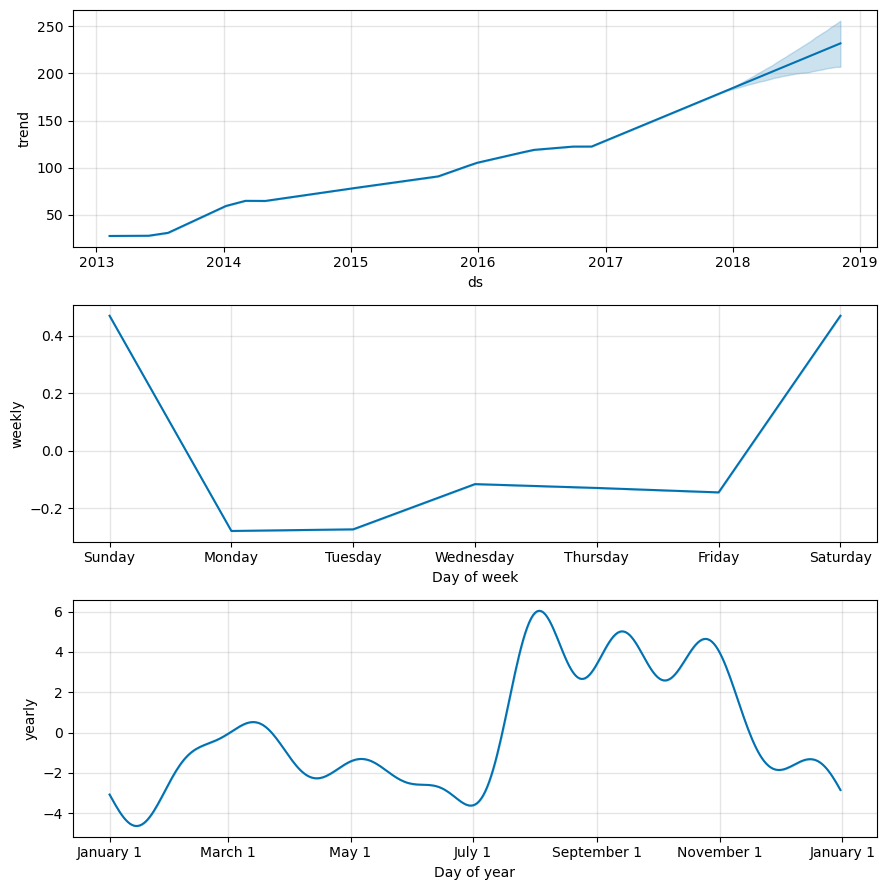

In [33]:
# Hàm để tách dữ liệu thành tập huấn luyện và tập kiểm tra cho mô hình Prophet
def prophet_split(df, co_name):
    size = int(len(df) * 0.95)  # Tính kích thước của tập huấn luyện (95%)
    train_df = df[:size]         # Tập huấn luyện
    test_df = df[size:]           # Tập kiểm tra
    
    print(f"Dữ liệu tách cho công ty {co_name}")
    print(f"Kích thước tập huấn luyện: {len(train_df)}, Kích thước tập kiểm tra: {len(test_df)}")
    print("-------------------------------")
    
    return train_df, test_df

# Tách dữ liệu cho AAPL và FB
apl_train, apl_test = prophet_split(aplph_df, 'APPLE')
fb_train, fb_test = prophet_split(fbph_df, 'FB')

# Hàm dự đoán giá sử dụng Prophet
def price_forecasting(train_df, test_df, period=365):

    # Khởi tạo mô hình Prophet
    prophet = Prophet(yearly_seasonality='auto')
    prophet.fit(train_df)

    # Tạo bảng dữ liệu cho tương lai
    future_price = prophet.make_future_dataframe(periods=period)
    forecasts = prophet.predict(future_price)

    # Chọn các cột cần thiết
    forecast = forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(period)

    # Vẽ biểu đồ dự đoán
    fig = prophet.plot(forecasts)
    a = add_changepoints_to_plot(fig.gca(), prophet, forecasts)

    # Vẽ các thành phần
    fig2 = prophet.plot_components(forecasts)

    return forecast, test_df  # Trả về dự đoán và dữ liệu test

# Dự đoán giá cho AAPL và FB
forecast_aapl, test_aapl = price_forecasting(apl_train, apl_test, period=365)
forecast_fb, test_fb = price_forecasting(fb_train, fb_test, period=365)

# **Xây dựng mô hình ARIMA (p,d,q) và dự báo** 

In [39]:
#Đọc dữ liệu
aplph_df = pd.read_csv(r'D:\download\mymy\TSE\aplph.csv')
fbph_df=pd.read_csv(r'D:\download\mymy\TSE\fbph.csv')
aplph_df.set_index('ds', inplace=True)
print(aplph_df.head())
print("\n")
fbph_df.set_index('ds', inplace=True)
print(fbph_df.head())

                  y
ds                 
2013-02-08  67.8542
2013-02-11  68.5614
2013-02-12  66.8428
2013-02-13  66.7156
2013-02-14  66.6556


                  y
ds                 
2013-02-08  28.5450
2013-02-11  28.2600
2013-02-12  27.3700
2013-02-13  27.9075
2013-02-14  28.5000


Kiểm tra tính dừng

In [40]:
# Kiểm định ADFuller
def adfuller_test(df):
    adfuller_result = adfuller(df['y'], autolag='AIC')
    adfuller_output = pd.Series(adfuller_result[:4], index=['Test statistic', 'p-value',
                                                           'Lags Used', 'Number of Observations Used'])
    print(adfuller_output)
print("adfuller test results for APPLE")
adfuller_test(aplph_df)
print("----"*10)
print("adfuller test results for FB")
adfuller_test(fbph_df)

adfuller test results for APPLE
Test statistic                   -0.665091
p-value                           0.855586
Lags Used                         0.000000
Number of Observations Used    1258.000000
dtype: float64
----------------------------------------
adfuller test results for FB
Test statistic                    0.177529
p-value                           0.970973
Lags Used                         8.000000
Number of Observations Used    1250.000000
dtype: float64


Tìm bậc của sai phân (vì dữ liệu chưa dừng) và lấy sai phân

In [41]:
#from pmdarima.arima.utils import ndiffs
# Tìm bậc của sai phân
def degree_of_differencing(df, co_name):
    company_ndiffs = ndiffs(df['y'], test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {co_name}')
    return company_ndiffs
aapl_ddf = degree_of_differencing(aplph_df, 'APPLE')
fb_ddf = degree_of_differencing(fbph_df, 'Facebook')
# Lấy sai phân
def apply_differencing(df, n_diff):
    for _ in range(n_diff):
        df['y'] = df['y'].diff()
    df = df.dropna().reset_index(drop=True)  # Bỏ giá trị NaN
    return df
# Lấy sai phân cho APPLE và FB
aplph_df_differenced = apply_differencing(aplph_df, aapl_ddf)
fbph_df_differenced = apply_differencing(fbph_df, fb_ddf)
# Kết quả ADF sau khi lấy sai phân
print("ADF test results for differenced APPLE:")
adfuller_test(aplph_df_differenced)
print("ADF test results for differenced FB:")
adfuller_test(fbph_df_differenced)


The degree of differencing is 1 for APPLE
The degree of differencing is 1 for Facebook
ADF test results for differenced APPLE:
Test statistic                  -34.820091
p-value                           0.000000
Lags Used                         0.000000
Number of Observations Used    1257.000000
dtype: float64
ADF test results for differenced FB:
Test statistic                -1.448415e+01
p-value                        6.301339e-27
Lags Used                      7.000000e+00
Number of Observations Used    1.250000e+03
dtype: float64


Vẽ biểu đồ ACF và PACF

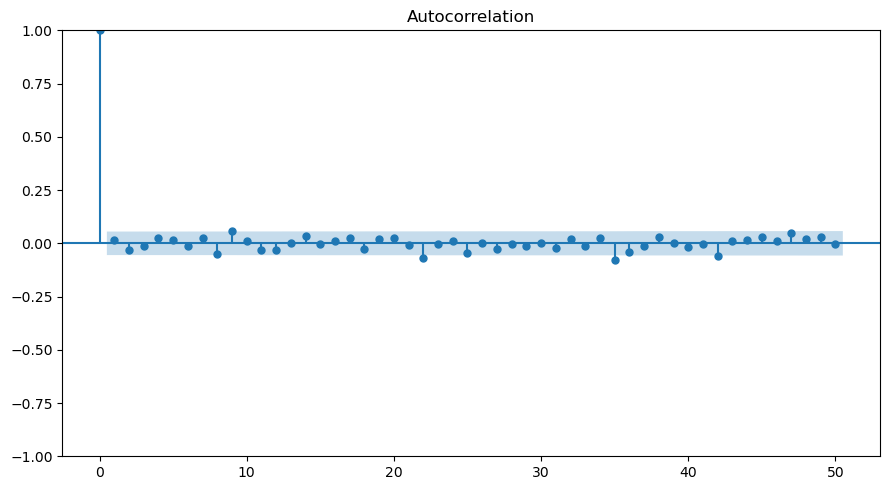

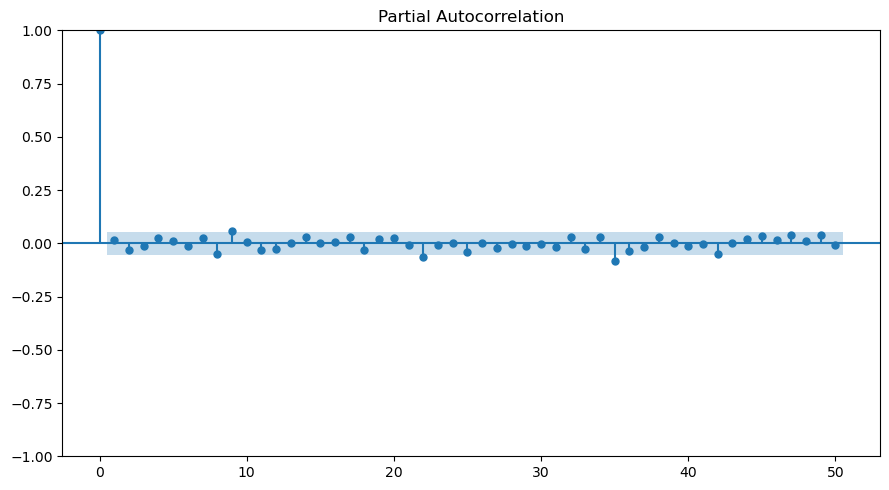

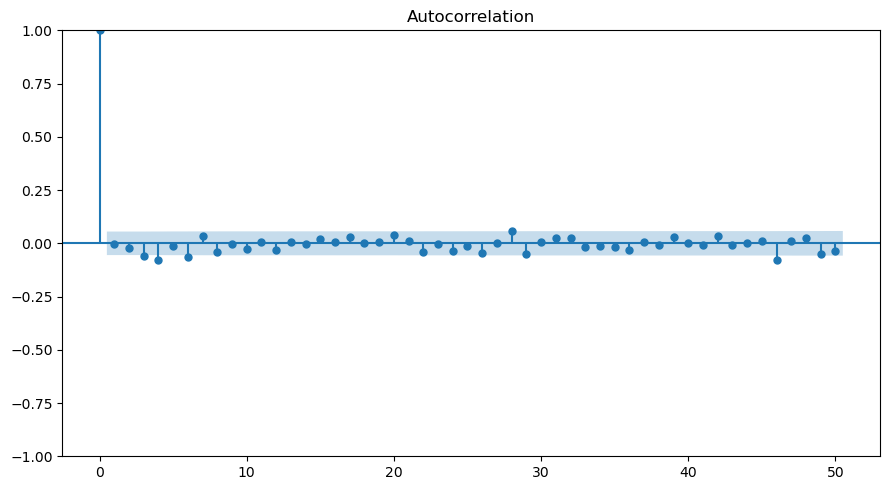

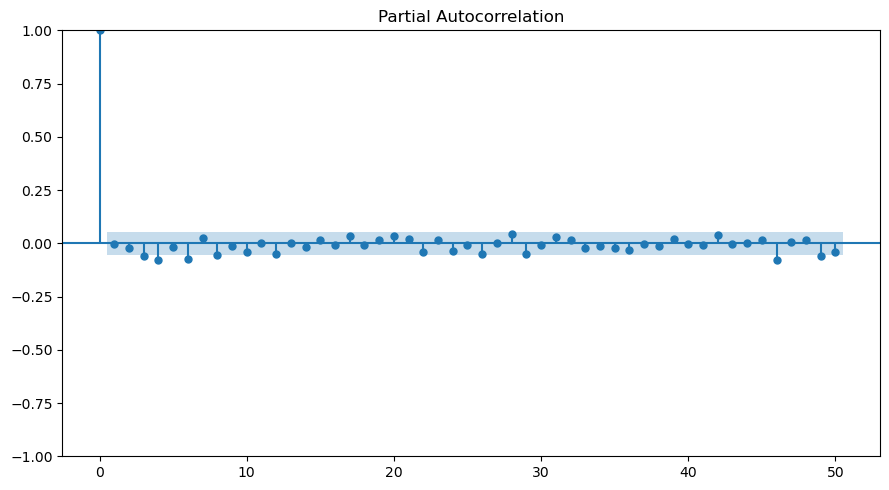

In [42]:
# Biểu đồ ACF và PACF
def acf_pacf(df, lags):
    var = df['y']
    # Vẽ biểu đồ ACF
    fig = plot_acf(var, lags=lags)
    fig.set_size_inches((9, 5))
    fig.tight_layout()
    plt.show()    
    # Vẽ biểu đồ PACF
    fig = plot_pacf(var, lags=lags)
    fig.set_size_inches((9, 5))
    fig.tight_layout()
    plt.show()
# ACF và PACF của giá cổ phiếu APPLE
acf_pacf(aplph_df_differenced, 50)
# ACF và PACF của giá cổ phiếu FB
acf_pacf(fbph_df_differenced, 50)

In [43]:
#Đọc dữ liệu
aplph_df = pd.read_csv(r'D:\download\mymy\TSE\aplph.csv')
fbph_df=pd.read_csv(r'D:\download\mymy\TSE\fbph.csv')
aplph_df.set_index('ds', inplace=True)
print(aplph_df.head())
print("\n")
fbph_df.set_index('ds', inplace=True)
print(fbph_df.head())

                  y
ds                 
2013-02-08  67.8542
2013-02-11  68.5614
2013-02-12  66.8428
2013-02-13  66.7156
2013-02-14  66.6556


                  y
ds                 
2013-02-08  28.5450
2013-02-11  28.2600
2013-02-12  27.3700
2013-02-13  27.9075
2013-02-14  28.5000


Chia dữ liệu chuỗi thời gian thành tập huấn luyện và kiểm tra

In [44]:
# Chia dữ liệu chuỗi thời gian thành tập huấn luyện và kiểm tra
def arima_split(df, co_name):
    size = int(len(df)*0.95)
    train_df = (df['y'])[:size]
    test_df = (df['y'])[size:]
    
    print(f"data splits of company {co_name}")
    print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")
    print("-------------------------------")
    
    return train_df, test_df

apl_train, apl_test = arima_split(aplph_df, 'APPLE')
fb_train, fb_test = arima_split(fbph_df, 'FB')

data splits of company APPLE
Train Size: 1196, Test Size: 63
-------------------------------
data splits of company FB
Train Size: 1196, Test Size: 63
-------------------------------


Tìm kiếm mô hình ARIMA tối ưu và vẽ biểu đồ

In [53]:
def find_best_fit_arima(df, co_name):
    print(f"Arima model for {co_name}")
    
    # Áp dụng mô hình ARIMA
    model = pm.auto_arima(df, 
                          start_p=1, 
                          start_q=1, 
                          max_p=5, 
                          max_q=5, 
                          test='adf', 
                          seasonal=False, 
                          trace=True)
    
    print(model.summary())
    print('\n')
    
    return model



model_apl = find_best_fit_arima(aplph_df, 'APPLE')
model_fb = find_best_fit_arima(fbph_df, 'FB')

Arima model for APPLE
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4718.052, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4716.112, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4717.820, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4717.799, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4716.804, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.242 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2356.056
Date:                Fri, 29 Nov 2024   AIC                           4716.112
Time:                        07:41:51   BIC                           4726.386
Sample:                             0   HQIC                          4719.973
                               - 1259                 

Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự báo

In [46]:
def find_best_fit_arima_with_statsmodels(df, co_name, order):
    print(f"ARIMA model for {co_name}")

    # Xây dựng và huấn luyện mô hình ARIMA
    model = ARIMA(df, order=order)
    model_fit = model.fit()

    # Hiển thị thông tin về mô hình
    print(model_fit.summary())
    print("\n")

    # Vẽ biểu đồ dữ liệu và giá trị dự báo
    plt.figure(figsize=(10, 6))
    plt.plot(df, color='blue')
    plt.plot(model_fit.fittedvalues, color='red')

    return model_fit


ARIMA model for APPLE
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1259
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2357.402
Date:                Fri, 29 Nov 2024   AIC                           4716.804
Time:                        07:40:00   BIC                           4721.942
Sample:                             0   HQIC                          4718.735
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.4843      0.057     43.793      0.000       2.373       2.595
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               887.90
Prob(Q):                 

C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



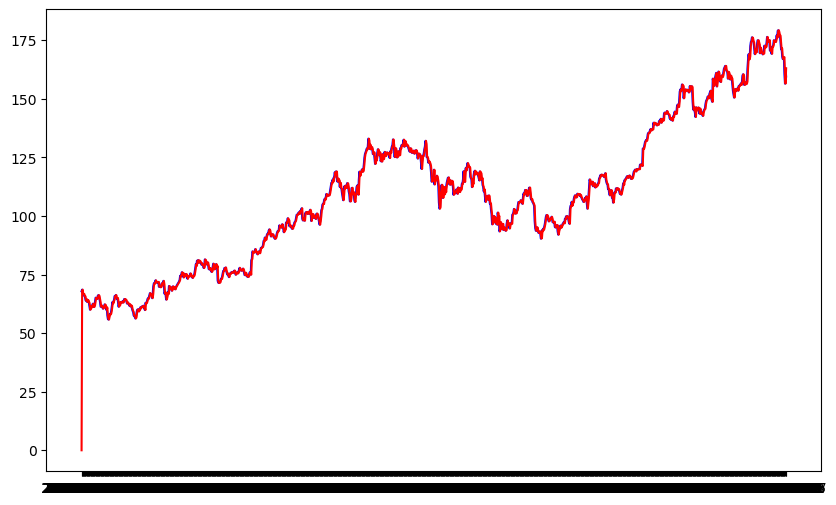

In [47]:
model_apl = find_best_fit_arima_with_statsmodels(aplph_df, 'APPLE', order=(0,1,0))

ARIMA model for FB


C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using z

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1259
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -2388.755
Date:                Fri, 29 Nov 2024   AIC                           4791.511
Time:                        07:40:09   BIC                           4827.472
Sample:                             0   HQIC                          4805.025
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2738      0.119     -2.308      0.021      -0.506      -0.041
ar.L2          0.6460      0.117      5.521      0.000       0.417       0.875
ar.L3         -0.0579      0.029     -2.021      0.0

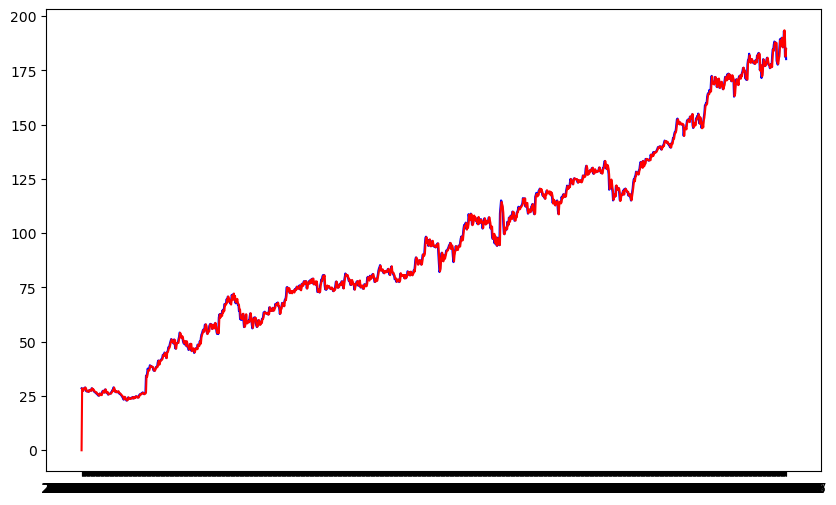

In [48]:
model_fb = find_best_fit_arima_with_statsmodels(fbph_df, 'FB', order=(4,1,2))

Dự báo 10 giá trị tiếp theo

In [49]:
def forecast_arima_model(model_fit, forecast_steps=10):
    # Dự báo tương lai
    forecast = model_fit.forecast(steps=forecast_steps)
    print(f"Forecast for the next {forecast_steps} steps:")
    print(forecast)

    return forecast

print("Dự báo 10 giá trị tiếp theo của Apple")
forecast_apl = forecast_arima_model(model_apl, forecast_steps=10)
print("----"*10)
print("Dự báo 10 giá trị tiếp theo của Facebook")
forecast_fb = forecast_arima_model(model_fb, forecast_steps=10)

Dự báo 10 giá trị tiếp theo của Apple
Forecast for the next 10 steps:
1259    159.54
1260    159.54
1261    159.54
1262    159.54
1263    159.54
1264    159.54
1265    159.54
1266    159.54
1267    159.54
1268    159.54
Name: predicted_mean, dtype: float64
----------------------------------------
Dự báo 10 giá trị tiếp theo của Facebook
Forecast for the next 10 steps:
1259    181.003365
1260    181.098308
1261    181.570004
1262    181.874252
1263    182.022779
1264    182.143556
1265    182.150207
1266    182.192907
1267    182.166360
1268    182.190946
Name: predicted_mean, dtype: float64


C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



# **Đánh giá 2 mô hình bằng chỉ số MAPE**

Tính chỉ số MAPE của mô hình PROPHET

In [23]:
# Hàm tính MAPE cho mô hình Prophet
def calculate_mape(actual, predicted,co_name):
    print(f"Dự báo và chỉ số MAPE mô hình Prophet của {co_name}")
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Tính MAPE cho AAPL
mape_aapl = calculate_mape(test_aapl['y'].values, forecast_aapl['yhat'].values[-len(test_aapl):],'APPLE')
print(f"MAPE là: {mape_aapl:.4f}")  # In ra với 4 chữ số thập phân

# Tính MAPE cho FB
mape_fb = calculate_mape(test_fb['y'].values, forecast_fb['yhat'].values[-len(test_fb):],'FACEBOOK')
print(f"MAPE là: {mape_fb:.4f}")  # In ra với 4 chữ số thập phân

Dự báo và chỉ số MAPE mô hình Prophet của APPLE
MAPE là: 24.4719
Dự báo và chỉ số MAPE mô hình Prophet của FACEBOOK
MAPE là: 27.5703


Tính chỉ số MAPE của mô hình ARIMA

In [54]:
#Hàm dự báo và in ra chỉ số MAPE của mô hình ARIMA

def make_predictions_and_print_mape(model, test_df, co_name):
    print(f"Dự báo và MAPE của {co_name}")
    
    # Thực hiện dự báo
    forecast, confidence_interval = model.predict(X=test_df, n_periods=len(test_df), return_conf_int=True)
    forecasts = pd.Series(forecast, index=test_df.index)
    lower = pd.Series(confidence_interval[:, 0], index=test_df.index)
    upper = pd.Series(confidence_interval[:, 1], index=test_df.index)
    
    # Tính toán MAPE
    mape = np.mean(np.abs((test_df.values - forecast) / test_df.values)) * 100
    
    print(f"MAPE của {co_name} là:", mape)
    
    return forecasts, lower, upper

# Sử dụng
forecast_apl, lower_apl, upper_apl = make_predictions_and_print_mape(model_apl, apl_test, 'APPLE')
print("----------------------------")
forecast_fb, lower_fb, upper_fb = make_predictions_and_print_mape(model_fb, fb_test, 'FB')

Dự báo và MAPE của APPLE
MAPE của APPLE là: 6.170068577696853
----------------------------
Dự báo và MAPE của FB
MAPE của FB là: 3.180054053011482


C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\MY\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

